# 📌 Task Definition
The goal of this project is binary classification of colonoscopy images into two categories:

*   haslumen – images containing visible lumen
*   nolumen – images without a clearly visible lumen


# 1. Load and Split Dataset
---
Images are categorized into two folders: `haslumen` and `nolumen`.

**Total images: 10559**
  - Lumen: 5469
  - No Lumen: 5090  

**Train/Validation/Test split:**

*   10% -> Test set
*   10% -> Validation set
*   80% -> Train set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/iMIAP_Project_lifesky/haslumen.zip" -d "/content/extracted"

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted/haslumen/case_M_20181010094822_0U62363101085921_1_003_001-1_a8_ayy_image0291.jpg  
  inflating: /content/extracted/haslumen/case_M_20181010094822_0U62363101085921_1_003_001-1_a8_ayy_image0301.jpg  
  inflating: /content/extracted/haslumen/case_M_20181010094822_0U62363101085921_1_003_001-1_a8_ayy_image0311.jpg  
  inflating: /content/extracted/haslumen/case_M_20181015093223_0U62372101593722_1_007_002-1_a12_ayy_image0001.jpg  
  inflating: /content/extracted/haslumen/case_M_20181015093223_0U62372101593722_1_007_002-1_a12_ayy_image0010.jpg  
  inflating: /content/extracted/haslumen/case_M_20181015093223_0U62372101593722_1_007_002-1_a12_ayy_image0020.jpg  
  inflating: /content/extracted/haslumen/case_M_20181015093223_0U62372101593722_1_007_002-1_a12_ayy_image0030.jpg  
  inflating: /content/extracted/haslumen/case_M_20181015093223_0U62372101593722_1_007_002-1_a12_ayy_image0040.jpg  
  inflating: /content/ex

In [ ]:
!unzip "/content/drive/MyDrive/iMIAP_Project_lifesky/nolumen.zip" -d "/content/extracted"

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0230.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0240.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0250.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0260.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0270.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0280.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0290.jpg  
  inflating: /content/extracted/nolumen/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0300.jpg  
  inflating: /content/extract

In [ ]:
# --- Paths ---
dataset_root_path = "/content/extracted"
model_save_path = "/content/drive/MyDrive/iMIAP_Project_lifesky/mobilenetv3small_bce_adam.pth"


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# --- Transformations ---
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# --- Load Dataset ---
full_dataset = datasets.ImageFolder(root=dataset_root_path, transform=train_transform)
class_names = full_dataset.classes
print(f"🔍 Detected classes: {full_dataset.class_to_idx}")

# --- Split Dataset ---
# Train 80%  + validation 10% + test 10%
val_size = int(len(full_dataset) * 0.1)
test_size = int(len(full_dataset) * 0.1)
train_size = len(full_dataset) - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size ,test_size ])
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# --- Data Loaders ---
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

🔍 Detected classes: {'haslumen': 0, 'nolumen': 1}


# 2. Training Phase
---

We used MobileNetV3 Small, a lightweight convolutional neural network, pre-trained on ImageNet and fine-tuned for our binary classification task. Final layer adapted to output a single logit → Binary classification with BCEWithLogitsLoss

*   **Model:** MobileNet V3 small
*   **Weights:** Pretrained
*   **Loss Function:** BCEWithLogitsLoss for binary output
*   **Optimizer:**
    -  Adam optimizer with learning rate 1e-4
    -  Learning rate scheduling using ReduceLROnPlateau
    -  Early stopping based on validation loss


In [ ]:
import gc
import torch
from torchvision import models
from torchsummary import summary

gc.collect()
torch.cuda.empty_cache()

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- Load MobileNetV3 Small ---
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)  # Binary classification
model = model.to(device)

# --- Print the model summary ---
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Loss and Optimizer ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# --- Training ---
EPOCHS = 15
PATIENCE = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = None

train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert to float

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f"\n📊 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")
    print(f"📉 Current LR: {optimizer.param_groups[0]['lr']}")

    scheduler.step(val_loss)

# --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
        print("✅ Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# --- Save Best Model ---
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_save_path)
    print(f"\n📦 Best model saved to: {model_save_path}")

✅ Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 23.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to a


📊 Epoch [1/15]
Train Loss: 0.3130 | Val Loss: 0.2194 | Val Acc: 90.43%
📉 Current LR: 0.0001
✅ Validation loss improved. Model saved.

📊 Epoch [2/15]
Train Loss: 0.1879 | Val Loss: 0.1840 | Val Acc: 92.70%
📉 Current LR: 0.0001
✅ Validation loss improved. Model saved.

📊 Epoch [3/15]
Train Loss: 0.1327 | Val Loss: 0.1830 | Val Acc: 93.18%
📉 Current LR: 0.0001
✅ Validation loss improved. Model saved.

📊 Epoch [4/15]
Train Loss: 0.0906 | Val Loss: 0.1924 | Val Acc: 92.61%
📉 Current LR: 0.0001
⚠️ No improvement. Patience 1/3

📊 Epoch [5/15]
Train Loss: 0.0571 | Val Loss: 0.2074 | Val Acc: 94.31%
📉 Current LR: 0.0001
⚠️ No improvement. Patience 2/3

📊 Epoch [6/15]
Train Loss: 0.0458 | Val Loss: 0.2150 | Val Acc: 93.55%
📉 Current LR: 0.0001
⚠️ No improvement. Patience 3/3
⏹️ Early stopping triggered.

📦 Best model saved to: /content/drive/MyDrive/iMIAP_Project_lifesky/mobilenetv3small_bce_adam.pth


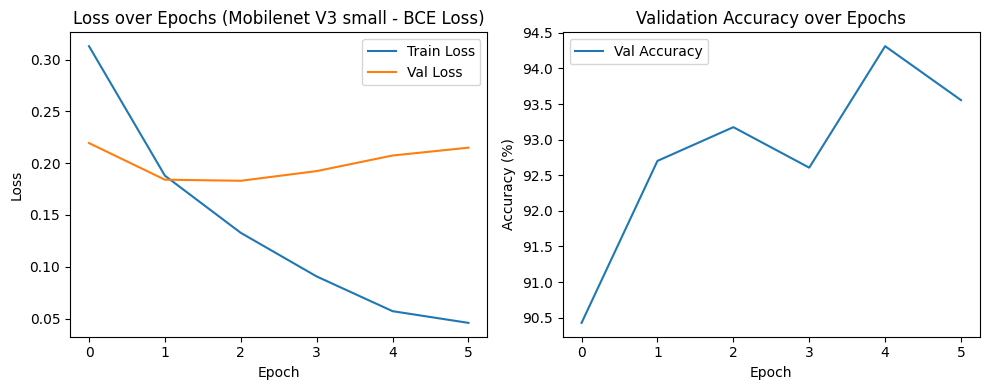

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs (Mobilenet V3 small - BCE Loss)")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Testing Phase

## Confusion Matrix and Report Metrics


📊 Classification Report on Test set:
              precision    recall  f1-score   support

    haslumen       0.96      0.93      0.94       535
     nolumen       0.93      0.96      0.94       520

    accuracy                           0.94      1055
   macro avg       0.94      0.94      0.94      1055
weighted avg       0.94      0.94      0.94      1055



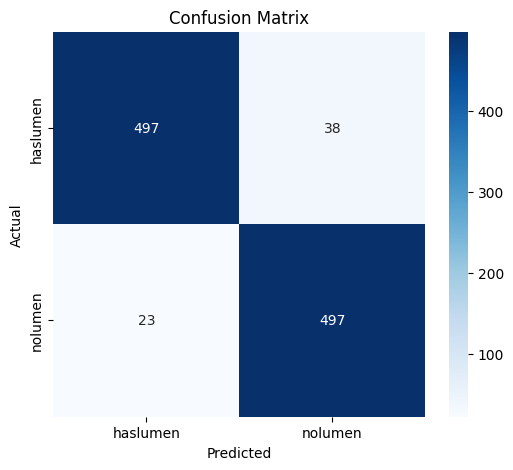

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).astype(int).flatten()
all_labels = np.array(all_labels).astype(int).flatten()

# Classification Report
print("\n📊 Classification Report on Test set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Test Samples
We visualize sample predictions from the test set:

*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

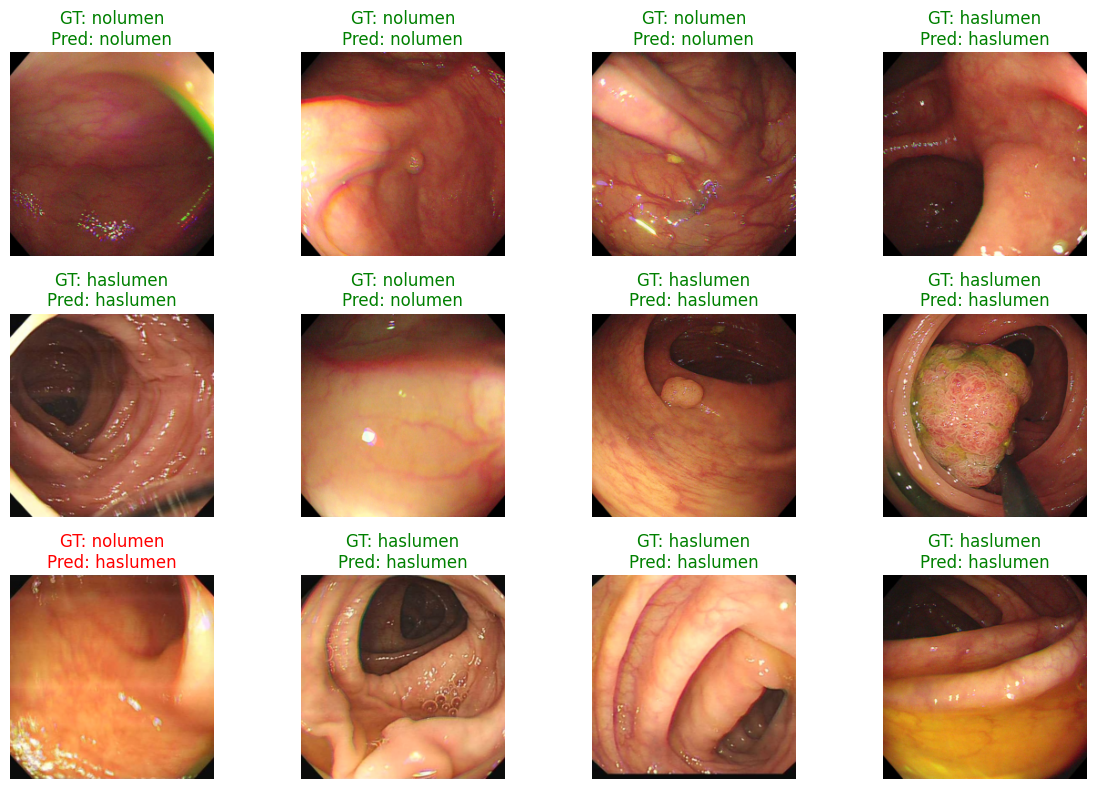

In [ ]:
model.eval()
shown = 0
plt.figure(figsize=(12, 8))

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs > 0.5).int()

        for i in range(len(imgs)):
            if shown >= 12: break  # Display 12 samples

            img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
            img_np = img_np.clip(0, 1)

            true_label = class_names[int(labels[i])]
            pred_label = class_names[int(preds[i])]
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(3, 4, shown + 1)
            plt.imshow(img_np)
            plt.title(f"GT: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

            shown += 1
        if shown >= 12: break

plt.tight_layout()
plt.show()

## Testing Robustness (Test with noisy inputs)

**We tested the model under image perturbations (data augmentations not seen during training), such as:**
*   Rotation
*   Brightness change
*   Blur

Outputs:
*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

**Observations**:

*  The model correctly classifies most variants.
*  Some errors occur when strong glare or blur is introduced.
*  Model shows moderate robustness to common perturbations.



For Example:

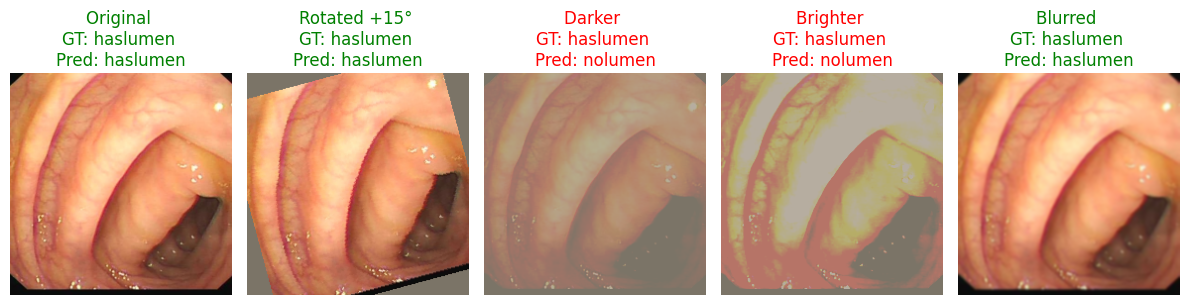

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

def predict(image_tensor):
    model.eval()
    with torch.no_grad():
        out = model(image_tensor)
        pred = torch.sigmoid(out) if isinstance(criterion, nn.BCEWithLogitsLoss) else torch.softmax(out, dim=1)
        return pred.cpu().numpy()

def plot_images_grid(images, title_colors ,titles=None, n_cols=3,figsize=(12, 6) ):
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)
    for idx, img in enumerate(images):

        img = img.squeeze().cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.clamp(0,1).permute(1,2,0).numpy()


        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[idx],color=title_colors[idx])
    plt.tight_layout()
    plt.show()

# Test some images from test set
for i in [0,10,25,50,80]:
    print(f"Testing Robustness of image {i+1} from Test set")
    img, label = test_dataset[i]
    img = img.unsqueeze(0).to(device)

    transforms_list = [
        ("Original", img),
        ("Rotated +15°", TF.rotate(img, angle=15)),
        ("Darker", TF.adjust_brightness(img, 0.5)),
        ("Brighter", TF.adjust_brightness(img, 1.5)),
        ("Blurred", TF.gaussian_blur(img, kernel_size=5))
    ]

    Title_Colors = []
    Images = []
    Titles = []

    for name, transformed_img in transforms_list:
        pred = predict(transformed_img)
        pred_label = np.argmax(pred) if pred.shape[1] > 1 else (pred > 0.5).astype(int)
        class_name = class_names[int(pred_label)]

        true_label = class_names[int(label)]
        color = 'green' if true_label == class_name else 'red'

        img_title = f"{name} \nGT: {true_label} \nPred: {class_name}"

        Images.append(transformed_img)
        Titles.append(img_title)
        Title_Colors.append(color)


    plot_images_grid(Images,Title_Colors, Titles,n_cols=5)


Output hidden; open in https://colab.research.google.com to view.

## Grad-CAM Visualization
**To understand the model’s focus areas dTo understand the model’s focus areas during prediction, we used Grad-CAM:**

*  Correct predictions: attention aligned with lumen or mucosal structures
*  Incorrect predictions: attention often distracted by artifacts (e.g., glare)

Output:
*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

**Observation:** Misclassifications often relate to poor lighting or ambiguity in lumen visibility. This insight can inform future preprocessing improvements (e.g., glare reduction, contrast normalization).



For Example:


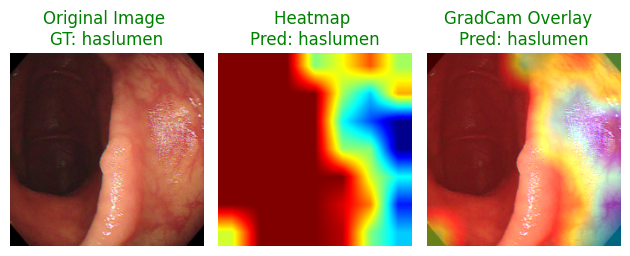

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s 

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Select the target convolutional layer for MobileNetV3 Small
target_layer = model.features[-1]  # Last Conv layer before classifier

# Hook variables
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks
handle_activ = target_layer.register_forward_hook(save_activation)
handle_grad = target_layer.register_backward_hook(save_gradient)

def generate_gradcam(input_tensor, model, target_class=None):
    model.eval()

    input_tensor = input_tensor.to(device)
    input_tensor.requires_grad = True

    output = model(input_tensor)

    # Apply sigmoid for BCEWithLogitsLoss
    probs = torch.sigmoid(output)

    if target_class is None:
        pred_class = (probs > 0.5).int().item()
    else:
        pred_class = target_class

    # Create scalar output for backward()
    class_score = probs[0][0] if pred_class == 0 else probs[0][1] if probs.shape[1] > 1 else probs[0]

    model.zero_grad()
    class_score.backward()

    # Global Average Pooling on gradients
    pooled_grads = torch.mean(gradients, dim=[0, 2, 3])  # shape: [C]

    # Weight activations
    cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(device)
    for i in range(len(pooled_grads)):
        cam += pooled_grads[i] * activations[0, i, :, :]

    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.detach().cpu().numpy()

    return cam, pred_class


def show_gradcam_on_image(img_tensor, cam,true_label, pred_label,color, alpha=0.5):
    img = img_tensor.squeeze().cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + img
    overlay = np.clip(overlay, 0, 1)  # Ensure valid range

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original Image \nGT: {true_label}",color=color)

    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f"Heatmap \nPred: {pred_label}",color=color)

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"GradCam Overlay  \nPred: {pred_label}",color=color)
    plt.tight_layout()
    plt.show()


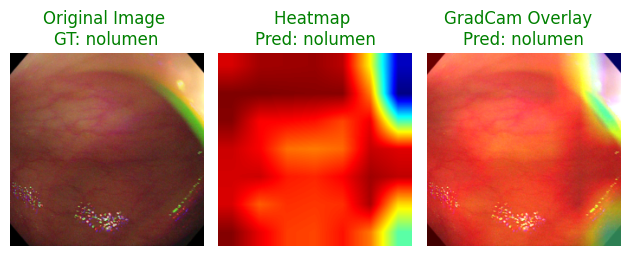

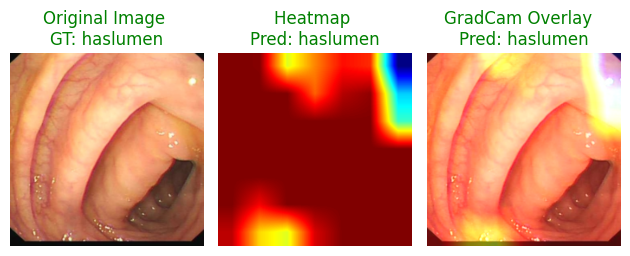

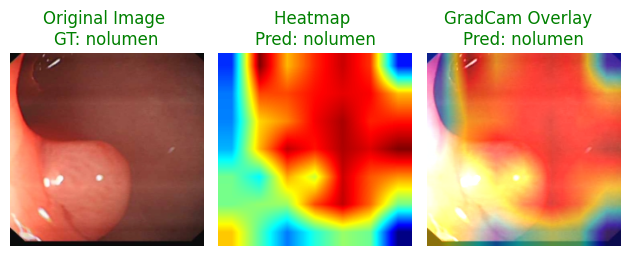

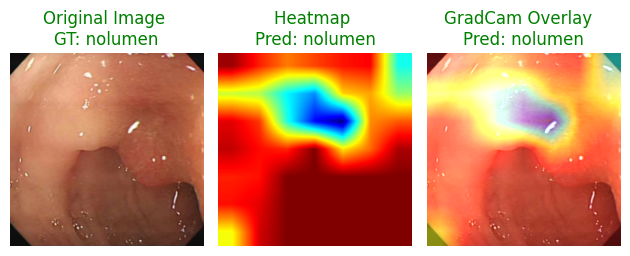

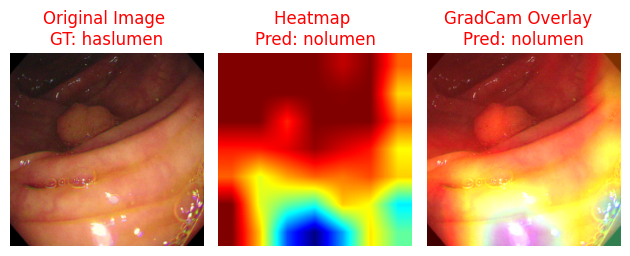

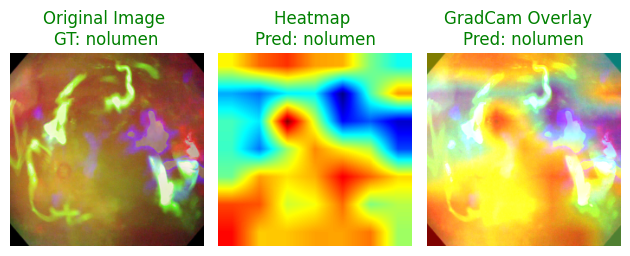

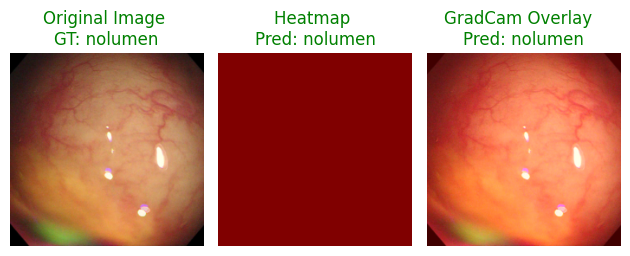

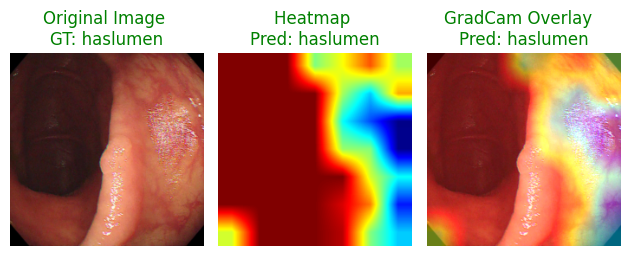

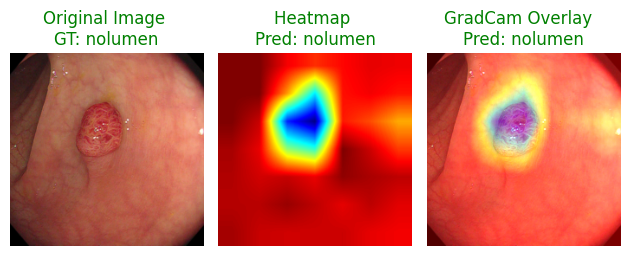

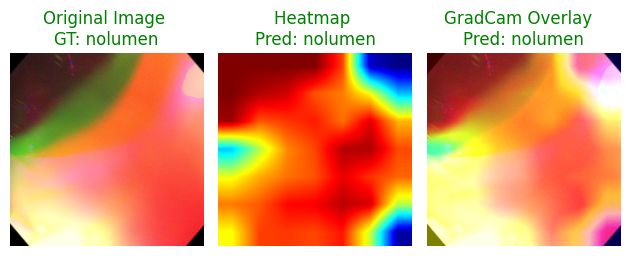

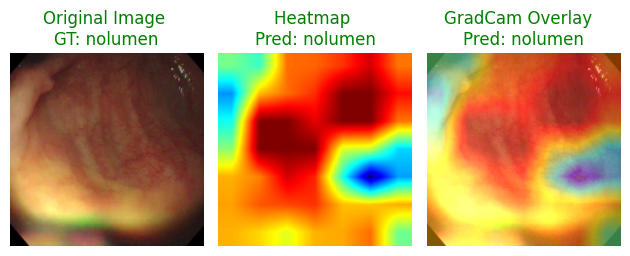

In [ ]:
num_imgs = np.arange(0, 101, 10)
for i in num_imgs:
    img_tensor, label = test_dataset[i]  # Get one image from test set
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension

    cam, pred = generate_gradcam(img_tensor, model) #pred is 0 or 1
    true_label = class_names[label]
    pred_label = class_names[pred]
    color = 'green' if true_label == pred_label else 'red'

    show_gradcam_on_image(img_tensor, cam, true_label, pred_label,color)

# 📌 Conclusion
**MobileNetV3 performed excellently with lightweight architecture and fast convergence.**

*  High accuracy on test set: 94%
*  Model is interpretable using Grad-CAM


**Further improvements can include:**

*  Better glare handling
*  More diverse training data
*  Ensemble or uncertainty estimation